# Titanic: Machine Learning from Disaster

The Titanic Kaggle competition can be found [at this link](https://www.kaggle.com/c/titanic/overview).

 - [Feature engineering](#Feature-engineering)
 - [Checking for correlations](#Checking-for-correlations)
 - [Model pipeline](#Model-pipeline)
 - [Grid search](#Grid-search)
   - [Support vector classifier](#Support-vector-classifier)
   - [Logistic regression](#Logistic-regression)
   - [Randomized grid search](#Randomized-grid-search)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
train_df = pd.read_csv('data/train.csv', na_values='NaN', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', na_values='NaN', index_col='PassengerId')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
train_df.describe().applymap('{:.2f}'.format)

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [7]:
test_df.describe().applymap('{:.2f}'.format)

,Pclass,Age,SibSp,Parch,Fare
count,418.00,332.00,418.00,418.00,417.00
mean,2.27,30.27,0.45,0.39,35.63
std,0.84,14.18,0.90,0.98,55.91
min,1.00,0.17,0.00,0.00,0.00
25%,1.00,21.00,0.00,0.00,7.90
50%,3.00,27.00,0.00,0.00,14.45
75%,3.00,39.00,1.00,0.00,31.50
max,3.00,76.00,8.00,9.00,512.33


In [8]:
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [9]:
train_df.drop('Ticket', axis=1, inplace=True)
test_df.drop('Ticket', axis=1, inplace=True)

## Feature engineering

I'm going to extract the title from the `Name` feature and create the `Title` feature to see if the title has any effect on the chance of survival, after which I'm going to discard the `Name` feature.

In [10]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split(' ')[1])

Just a quick fix, `the` which appears above is actually of part of `the Countess. of`, so I'm going to replace `the` with `Countess.`.

In [11]:
train_df['Title'].replace('the', 'Countess.', inplace=True)

In [12]:
train_df['Title'].value_counts(ascending=False)

Mr.          517
Miss.        182
Mrs.         125
Master.      40 
Dr.          7  
Rev.         6  
Col.         2  
Mlle.        2  
Major.       2  
Jonkheer.    1  
Don.         1  
Ms.          1  
Capt.        1  
Countess.    1  
Lady.        1  
Mme.         1  
Sir.         1  
Name: Title, dtype: int64

In [13]:
train_df.drop('Name', axis=1, inplace=True)

I'm going to create the `Family Size` feature to see if that has any effect on survival.

In [14]:
train_df['Family Size'] = train_df['Parch'] + train_df['SibSp'] + 1

In [15]:
train_df['Family Size'].value_counts(ascending=False)

1     537
2     161
3     102
4     29 
6     22 
5     15 
7     12 
11    7  
8     6  
Name: Family Size, dtype: int64

I'm going to replace the `NaN` values in `Embarked` with the mode of the feature column.

In [16]:
train_df['Embarked'].fillna(train_df['Embarked'].mode().values[0], inplace=True)

In a similar vein, I'm replacing the `NaN` values in `Fare` with the median of the feature column.

In [17]:
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

Finally, I'm replacing the `NaN` values in `Age` with the median of the feature.

In [18]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

In [19]:
train_df.isna().any()

Survived       False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Embarked       False
Title          False
Family Size    False
dtype: bool

In [20]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family Size
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr.,2
2,1,1,female,38.0,1,0,71.2833,C,Mrs.,2
3,1,3,female,26.0,0,0,7.9250,S,Miss.,1
4,1,1,female,35.0,1,0,53.1000,S,Mrs.,2
5,0,3,male,35.0,0,0,8.0500,S,Mr.,1


Let's do the same for the `test_df` data set.

In [21]:
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split(' ')[1])
test_df.drop('Name', axis=1, inplace=True)
test_df['Family Size'] = test_df['Parch'] + test_df['SibSp'] + 1
test_df['Embarked'].fillna(test_df['Embarked'].mode().values[0], inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

In [22]:
test_df.isna().any()

Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Embarked       False
Title          False
Family Size    False
dtype: bool

In [23]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family Size
PassengerId,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,Mr.,1
893,3,female,47.0,1,0,7.0000,S,Mrs.,2
894,2,male,62.0,0,0,9.6875,Q,Mr.,1
895,3,male,27.0,0,0,8.6625,S,Mr.,1
896,3,female,22.0,1,1,12.2875,S,Mrs.,3


## Checking for correlations

Unfortunately by generating the `Family Size` attribute, we haven't created a new feature that is correlated to the `Survived` feature.

In [24]:
train_df.corr()['Survived']

Survived       1.000000
Pclass        -0.338481
Age           -0.064910
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Family Size    0.016639
Name: Survived, dtype: float64

## Model pipeline

In [25]:
from model_pipeline import ModelPipeline, BinaryModelTraining, BinaryClassMetrics

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [27]:
cat_attrib = list(train_df.select_dtypes('object'))
num_attrib = list(set(train_df.columns) - set(cat_attrib) - set(['Survived']))

In [28]:
model_dict = {'Logistic regression': LogisticRegression(solver='newton-cg', n_jobs=-1, random_state=42), \
              'Stochastic gradient descent classifier': SGDClassifier(loss='log', random_state=42), \
              'Decision tree classifier': DecisionTreeClassifier(random_state=42), \
              'Random forest classifier': RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42), \
              'Support vector classifier': SVC(kernel='linear', gamma='scale', probability=True, random_state=42)}

In [29]:
mp = ModelPipeline(train_df, cat_attrib, num_attrib)
X_train, X_test, y_train, y_test = mp.full_pipeline()
bmt = BinaryModelTraining(X_train, X_test, y_train, y_test)
y_pred_results, y_pred_proba_results = bmt.train(model_dict)
bcm = BinaryClassMetrics(model_dict, y_pred_results, y_pred_proba_results)
bcm.compute_rmse(y_test)

Accuracy of the logistic regression on test set: 0.8172
Accuracy of the stochastic gradient descent classifier on test set: 0.8060
Accuracy of the decision tree classifier on test set: 0.7537
Accuracy of the random forest classifier on test set: 0.7948
Accuracy of the support vector classifier on test set: 0.8321
Time elapsed for training: 1.43 seconds

Root mean square error for the logistic regression model: 0.428
Root mean square error for the stochastic gradient descent classifier model: 0.440
Root mean square error for the decision tree classifier model: 0.496
Root mean square error for the random forest classifier model: 0.453
Root mean square error for the support vector classifier model: 0.410



In [30]:
bcm.compute_confusion_matrix(y_test)

Confusion matrix for the logistic regression model: 
[[133  24]
 [ 25  86]]

Confusion matrix for the stochastic gradient descent classifier model: 
[[136  21]
 [ 31  80]]

Confusion matrix for the decision tree classifier model: 
[[125  32]
 [ 34  77]]

Confusion matrix for the random forest classifier model: 
[[130  27]
 [ 28  83]]

Confusion matrix for the support vector classifier model: 
[[139  18]
 [ 27  84]]



In [31]:
bcm.compute_classification_report(y_test)

Precision, recall, F-measure and support for the logistic regression model: 
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       157
           1       0.78      0.77      0.78       111

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268


Precision, recall, F-measure and support for the stochastic gradient descent classifier model: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       157
           1       0.79      0.72      0.75       111

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.80       268


Precision, recall, F-measure and support for the decision tree classifier model: 
              precision    recall  f1-score   support

           0       0.79      0.80 

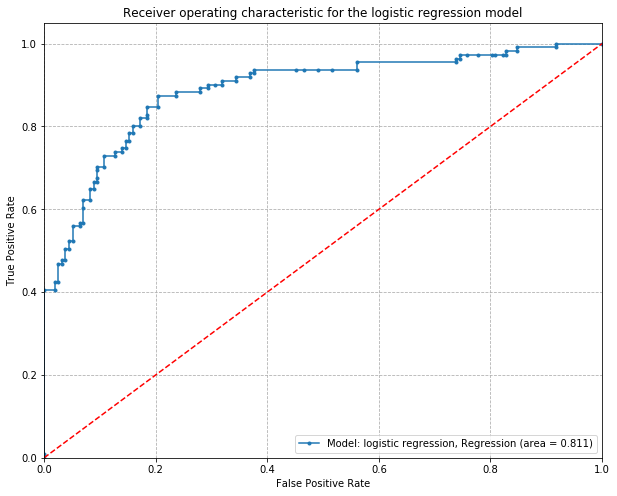

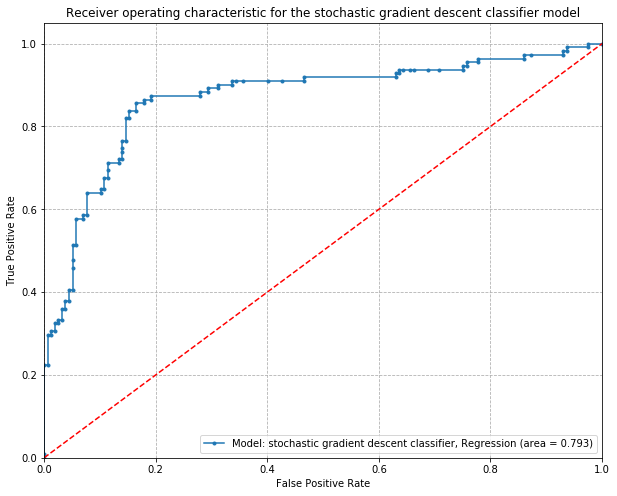

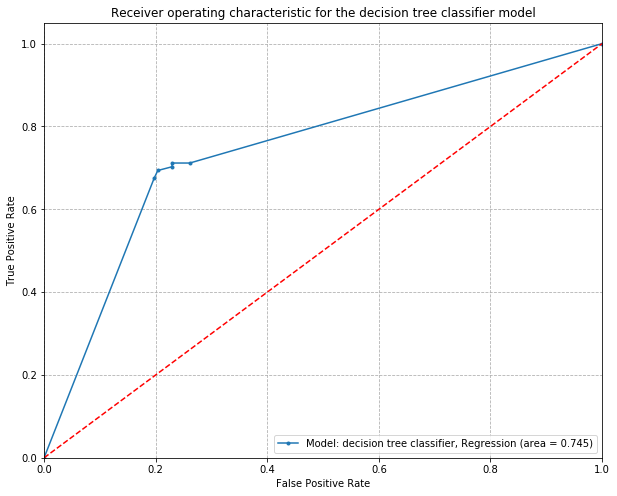

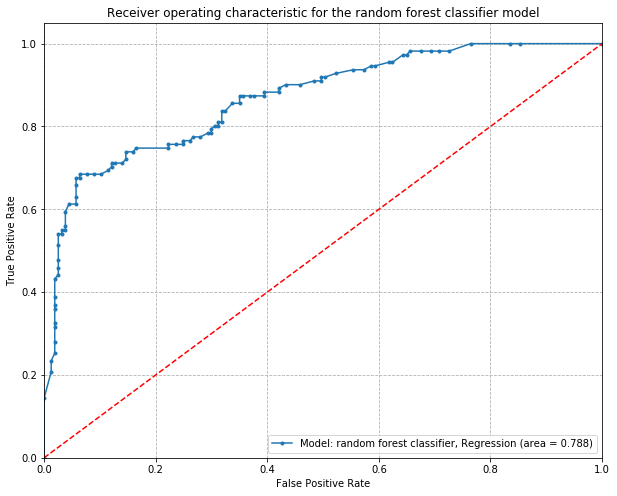

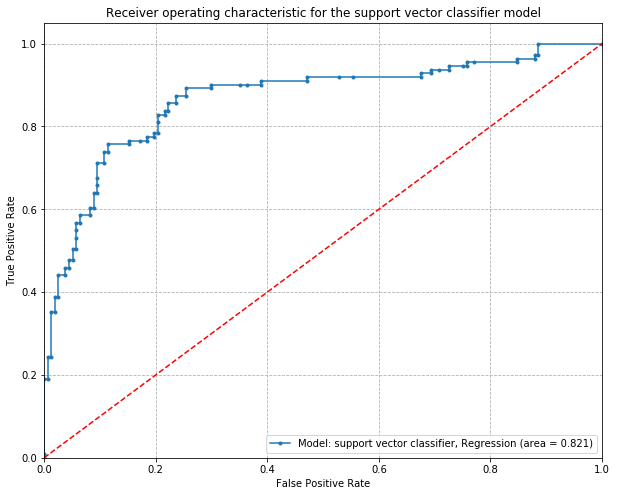

In [32]:
bcm.compute_plots(y_test)

It appears that the **support vector machine classifier** is the model with the best accuracy, root mean square and greatest ROC area under the curve. Let's try to do refine the parameters using grid search!

## Grid search

In [33]:
from parameter_search import BestParameterSearch

### Support vector classifier

In [34]:
svc = SVC()

In [35]:
param_grid = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4, 6], 'coef0': [0.1, 1.0, 10], \
               'C': [0.1, 1.0, 10], 'gamma': ['scale'], 'max_iter': [10000, 100000, 1000000], \
               'probability': [True], 'random_state': [42], 'coef0': [1, 10, 50], 'tol': [0.01, 0.001, 0.0001]}]

In [36]:
grid_search = BestParameterSearch(svc, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)

In [37]:
best_model, best_params_df = grid_search.best_fit_results(X_train, y_train)

/Applications/Computation/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Applications/Computation/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [38]:
best_model

SVC(C=10, cache_size=200, class_weight=None, coef0=50,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=10000, probability=True, random_state=42, shrinking=True, tol=0.01,
    verbose=False)

In [39]:
best_params_df.head(10)

,RMSE,Parameters
0,0.404628,"{'C': 10, 'coef0': 50, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 10000, 'probability': True, 'random_state': 42, 'tol': 0.001}"
1,0.404628,"{'C': 10, 'coef0': 50, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 10000, 'probability': True, 'random_state': 42, 'tol': 0.01}"
2,0.404628,"{'C': 10, 'coef0': 50, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 10000, 'probability': True, 'random_state': 42, 'tol': 0.0001}"
3,0.406607,"{'C': 10, 'coef0': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 10000, 'probability': True, 'random_state': 42, 'tol': 0.001}"
4,0.406607,"{'C': 10, 'coef0': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 10000, 'probability': True, 'random_state': 42, 'tol': 0.0001}"
5,0.408576,"{'C': 0.1, 'coef0': 50, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 1000000, 'probability': True, 'random_state': 42, 'tol': 0.0001}"
6,0.408576,"{'C': 0.1, 'coef0': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 1000000, 'probability': True, 'random_state': 42, 'tol': 0.0001}"
7,0.408576,"{'C': 0.1, 'coef0': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 1000000, 'probability': True, 'random_state': 42, 'tol': 0.001}"
8,0.408576,"{'C': 0.1, 'coef0': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 100000, 'probability': True, 'random_state': 42, 'tol': 0.0001}"
9,0.408576,"{'C': 0.1, 'coef0': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 100000, 'probability': True, 'random_state': 42, 'tol': 0.001}"


In [40]:
best_model_dict = {'Best support vector classifier': best_model}
bmt = BinaryModelTraining(X_train, X_test, y_train, y_test)
y_pred_results, y_pred_proba_results = bmt.train(best_model_dict)
bcm = BinaryClassMetrics(best_model_dict, y_pred_results, y_pred_proba_results)
bcm.compute_rmse(y_test)

Accuracy of the best support vector classifier on test set: 0.8209
Time elapsed for training: 0.22 seconds

Root mean square error for the best support vector classifier model: 0.423



/Applications/Computation/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [41]:
bcm.compute_confusion_matrix(y_test)

Confusion matrix for the best support vector classifier model: 
[[145  12]
 [ 36  75]]



In [42]:
bcm.compute_classification_report(y_test)

Precision, recall, F-measure and support for the best support vector classifier model: 
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       157
           1       0.86      0.68      0.76       111

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.82      0.82       268




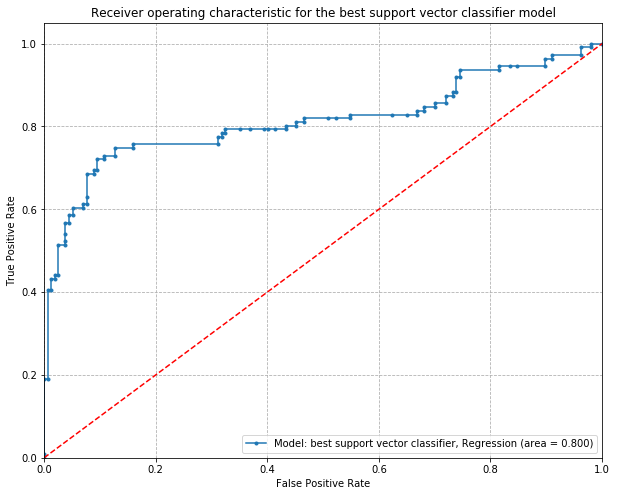

In [43]:
bcm.compute_plots(y_test)

### Logistic regression

In [44]:
log_reg = LogisticRegression()

In [45]:
param_grid = [{'penalty': ['l2'], 'C': [0.1, 1.0, 10], 'intercept_scaling': [1], \
               'class_weight': ['balanced'], 'random_state': [42], \
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  'warm_start': [True], \
               'max_iter': [100, 1000, 10000]}]

In [46]:
grid_search = BestParameterSearch(log_reg, param_grid, scoring='neg_mean_squared_error', cv=5, \
                                  return_train_score=True)

In [47]:
best_model, best_params_df = grid_search.best_fit_results(X_train, y_train)

/Applications/Computation/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [48]:
best_model

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=True)

In [49]:
best_params_df.head(10)

,RMSE,Parameters
0,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}"
1,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'warm_start': True}"
2,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'warm_start': True}"
3,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'warm_start': True}"
4,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'warm_start': True}"
5,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'warm_start': True}"
6,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'warm_start': True}"
7,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'warm_start': True}"
8,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'warm_start': True}"
9,0.440706,"{'C': 1.0, 'class_weight': 'balanced', 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}"


In [50]:
best_model_dict = {'Best logistic regression': best_model}
bmt = BinaryModelTraining(X_train, X_test, y_train, y_test)
y_pred_results, y_pred_proba_results = bmt.train(best_model_dict)
bcm = BinaryClassMetrics(best_model_dict, y_pred_results, y_pred_proba_results)
bcm.compute_rmse(y_test)

Accuracy of the best logistic regression on test set: 0.8172
Time elapsed for training: 0.01 seconds

Root mean square error for the best logistic regression model: 0.428



In [51]:
bcm.compute_confusion_matrix(y_test)

Confusion matrix for the best logistic regression model: 
[[130  27]
 [ 22  89]]



In [52]:
bcm.compute_classification_report(y_test)

Precision, recall, F-measure and support for the best logistic regression model: 
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       157
           1       0.77      0.80      0.78       111

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268




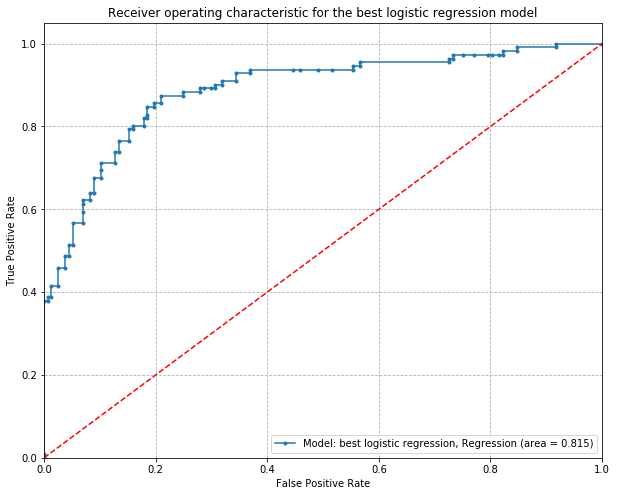

In [53]:
bcm.compute_plots(y_test)

## Randomized grid search

In [83]:
from sklearn.model_selection import RandomizedSearchCV

In [94]:
param_grid = {'penalty': ['l2'], 'C': [0.1, 1.0, 10, 20, 50, 100], 'intercept_scaling': [1], \
               'class_weight': ['balanced'], 'random_state': [42], \
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  'warm_start': [True], \
               'max_iter': [100, 1000, 10000, 100000, 1000000]}

In [95]:
randomized_search = RandomizedSearchCV(log_reg, n_jobs=-1, n_iter=10, param_distributions=param_grid, cv=5, \
                                      return_train_score=True)

In [96]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.1, 1.0, 10, 20, 50, 100],
                                        'class_weight': ['balanced'],
                                        'intercept_scaling': [1],
                                        'max_iter': [100, 1000, 

In [97]:
randomized_search.best_estimator_

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=True)

In [98]:
cvres = randomized_search.cv_results_

In [99]:
results = []
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    results.append({'RMSE': np.sqrt(mean_score), 'Parameters': params})
    best_params_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True).reset_index(drop=True)

In [100]:
best_params_df.head(20)

,RMSE,Parameters
0,0.892271,"{'warm_start': True, 'solver': 'lbfgs', 'random_state': 42, 'penalty': 'l2', 'max_iter': 1000000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 0.1}"
1,0.892271,"{'warm_start': True, 'solver': 'sag', 'random_state': 42, 'penalty': 'l2', 'max_iter': 1000000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 0.1}"
2,0.900330,"{'warm_start': True, 'solver': 'lbfgs', 'random_state': 42, 'penalty': 'l2', 'max_iter': 100000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 10}"
3,0.900330,"{'warm_start': True, 'solver': 'newton-cg', 'random_state': 42, 'penalty': 'l2', 'max_iter': 1000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 10}"
4,0.900330,"{'warm_start': True, 'solver': 'liblinear', 'random_state': 42, 'penalty': 'l2', 'max_iter': 1000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 100}"
5,0.900330,"{'warm_start': True, 'solver': 'newton-cg', 'random_state': 42, 'penalty': 'l2', 'max_iter': 100000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 20}"
6,0.900330,"{'warm_start': True, 'solver': 'sag', 'random_state': 42, 'penalty': 'l2', 'max_iter': 1000000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 20}"
7,0.900330,"{'warm_start': True, 'solver': 'liblinear', 'random_state': 42, 'penalty': 'l2', 'max_iter': 1000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 1.0}"
8,0.900330,"{'warm_start': True, 'solver': 'saga', 'random_state': 42, 'penalty': 'l2', 'max_iter': 100, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 50}"
9,0.900330,"{'warm_start': True, 'solver': 'newton-cg', 'random_state': 42, 'penalty': 'l2', 'max_iter': 100000, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 10}"
